# **Fashion MNIST Classification using Support Vector Machine (SVM)**

In [65]:
import warnings 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,log_loss,confusion_matrix,ConfusionMatrixDisplay, classification_report
from sklearn.decomposition import PCA
import pickle

warnings.filterwarnings('ignore')

# Splitting into Training, Validation and Test Sets

In [2]:
(X_train_raw,y_train_raw),(X_test,y_test) = fashion_mnist.load_data()

In [3]:
X_train_raw.shape,y_train_raw.shape

((60000, 28, 28), (60000,))

In [4]:
X_test.shape,y_test.shape

((10000, 28, 28), (10000,))

In [5]:
y_train_raw[0:10]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

In [6]:
X_train,X_val,y_train,y_val = train_test_split(X_train_raw,y_train_raw,test_size=1/6,shuffle=True,random_state=42)

In [7]:
X_train.shape,y_train.shape

((50000, 28, 28), (50000,))

In [8]:
X_val.shape,y_val.shape

((10000, 28, 28), (10000,))

In [9]:
X_test.shape,y_test.shape

((10000, 28, 28), (10000,))

# Defining Labels

In [10]:
y_labels = {0:"T-shirt/top",
            1:"Trouser",
            2:"Pullover",
            3:"Dress",
            4:"Coat",
            5:"Sandal",
            6:"Shirt",
            7:"Sneaker",
            8:"Bag",
            9:"Ankle boot"}

y_train_labels = [y_labels[i] for i in y_train]
y_val_labels = [y_labels[i] for i in y_val]
y_test_labels = [y_labels[i] for i in y_test]

print(y_train[0:10])
print(y_train_labels[0:10])

[5 0 0 1 4 5 6 8 6 9]
['Sandal', 'T-shirt/top', 'T-shirt/top', 'Trouser', 'Coat', 'Sandal', 'Shirt', 'Bag', 'Shirt', 'Ankle boot']


# Visualizing the Fashion MNIST

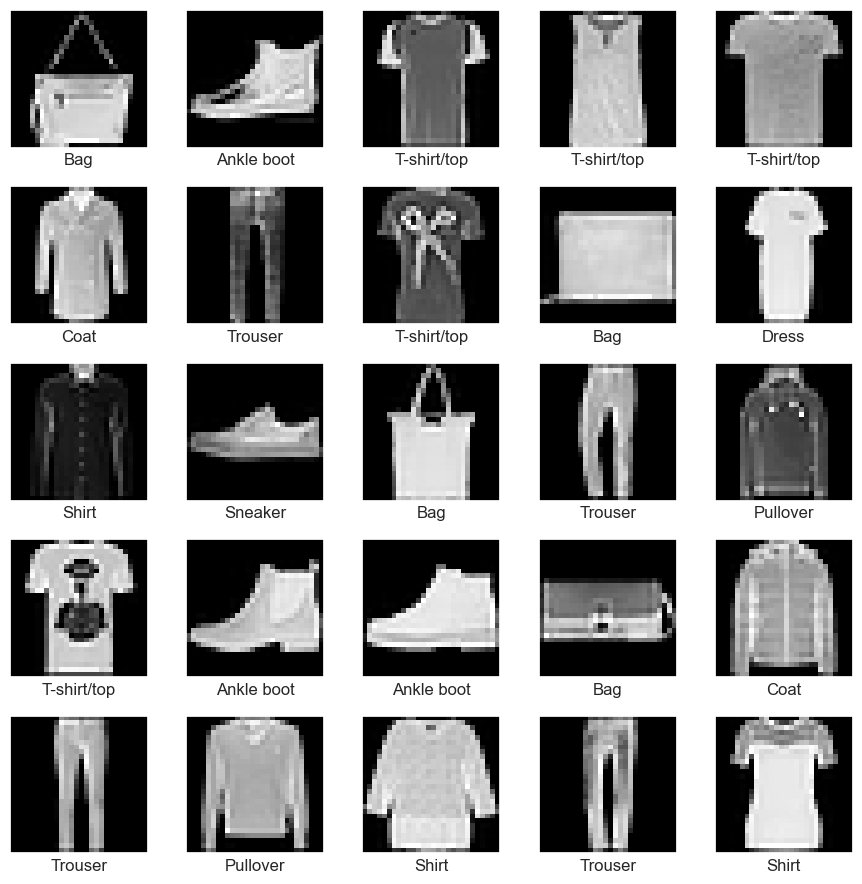

In [11]:
sns.set()
plt.figure(figsize=(9,9))
for i,j in zip(range(25),np.random.randint(0,X_train.shape[0],25)):
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[j],cmap='gray')
    plt.tick_params(bottom=False,labelbottom=False,left=False,labelleft=False)
    plt.xlabel(y_train_labels[j])
    plt.grid(False)
plt.tight_layout()

In [12]:
pd.DataFrame(y_train_labels).value_counts()

Sneaker        5053
Coat           5003
Pullover       5003
Bag            4999
Trouser        4998
Ankle boot     4992
Dress          4992
T-shirt/top    4991
Sandal         4985
Shirt          4984
Name: count, dtype: int64

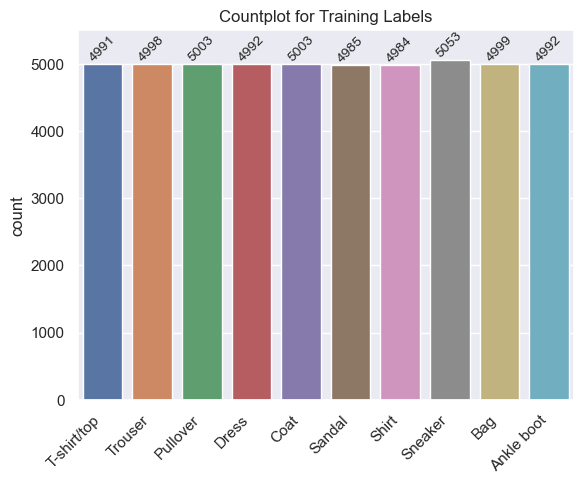

In [13]:
ax = sns.countplot(x=y_train_labels,
                   order=[y_labels[i] for i in range(len(y_labels))])

ax.bar_label(ax.containers[0],
             fontsize=10,
             rotation=45)

plt.xticks(rotation=45,
           horizontalalignment='right')

plt.ylim(0,5500)
plt.title('Countplot for Training Labels')
plt.show()

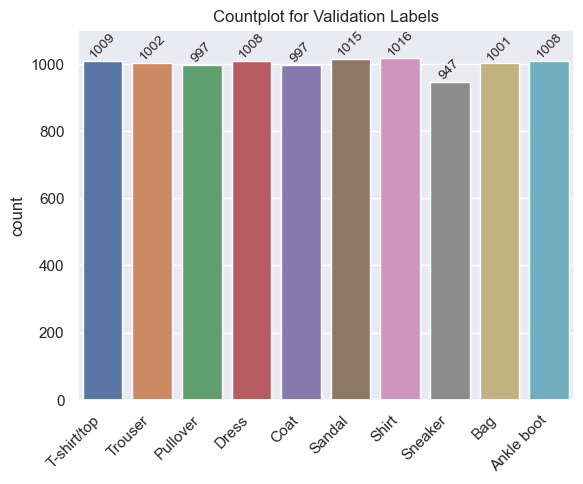

In [14]:
ax = sns.countplot(x=y_val_labels,
                   order=[y_labels[i] for i in range(len(y_labels))])

ax.bar_label(ax.containers[0],
             fontsize=10,
             rotation=45)

plt.xticks(rotation=45,
           horizontalalignment='right')

plt.ylim(0,1100)
plt.title('Countplot for Validation Labels')
plt.show()

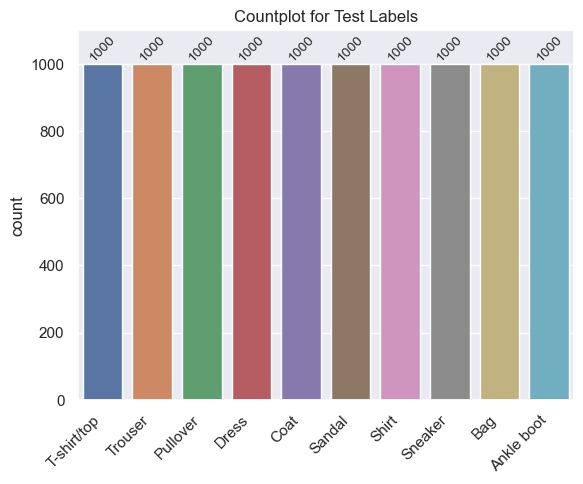

In [15]:
ax = sns.countplot(x=y_test_labels,
                   order=[y_labels[i] for i in range(len(y_labels))])

ax.bar_label(ax.containers[0],
             fontsize=10,
             rotation=45)

plt.xticks(rotation=45,
           horizontalalignment='right')

plt.ylim(0,1100)
plt.title('Countplot for Test Labels')
plt.show()

# Some Function Definitions

In [48]:
ss = StandardScaler()
pca = PCA(random_state=42)

def fit_transform(X,ss,pca):
    X_flattened = X.reshape(-1,28*28)
    X_scaled = ss.fit_transform(X_flattened)
    X_transformed = pca.fit_transform(X_scaled)
    return X_transformed

def transform(X,ss,pca):
    X_flattened = X.reshape(-1,28*28)
    X_scaled = ss.transform(X_flattened)
    X_transformed = pca.transform(X_scaled)
    return X_transformed

In [17]:
X_train_transformed = fit_transform(X_train,ss,pca)
X_val_transformed = transform(X_val,ss,pca)
X_test_transformed = transform(X_test,ss,pca)

In [38]:
def show_val_scores(y_train_pred,y_val_pred):
    scores = {
        "Training Accuracy" : accuracy_score(y_train,y_train_pred),
        "Validation Accuracy": accuracy_score(y_val,y_val_pred),
        "Training Precision": precision_score(y_train,y_train_pred,average='macro'),
        "Validation Precision": precision_score(y_val,y_val_pred,average='macro'),
        "Training Recall": recall_score(y_train,y_train_pred,average='macro'),
        "Validation Recall": recall_score(y_val,y_val_pred,average='macro'),
        "Training F1 Score": f1_score(y_train,y_train_pred,average='macro'),
        "Validation F1 Score": f1_score(y_val,y_val_pred,average='macro'),
    }
    for key in scores:
        scores[key] = round(scores[key],3)
    return scores

In [39]:
def show_test_scores(y_train_pred,y_test_pred):
    scores = {
        "Training Accuracy": accuracy_score(y_train,y_train_pred),
        "Testing Accuracy": accuracy_score(y_test,y_test_pred),
        "Training Precision": precision_score(y_train,y_train_pred,average='macro'),
        "Testing Precision": precision_score(y_test,y_test_pred,average='macro'),
        "Training Recall": recall_score(y_train,y_train_pred,average='macro'),
        "Testing Recall": recall_score(y_test,y_test_pred,average='macro'),
        "Training F1 Score": f1_score(y_train,y_train_pred,average='macro'),
        "Testing F1 Score": f1_score(y_test,y_test_pred,average='macro'),
    }
    for key in scores:
        scores[key] = round(scores[key],3)
    return scores

In [30]:
def show_confusion_matrix(y_true,y_pred):
    cm = confusion_matrix(y_true,y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2,3,4,5,6,7,8,9])
    disp.plot()
    plt.grid(False)
    plt.show()

# Plain SVM

Let us fit our data on the default Support Vector Classifier (SVC).

In [60]:
%%time
svc = SVC(random_state=42)
svc.fit(X_train_transformed,y_train)

CPU times: total: 4min 2s
Wall time: 4min 17s


SVC(random_state=42)

In [61]:
y_train_pred_svc = svc.predict(X_train_transformed)
y_val_pred_svc = svc.predict(X_val_transformed)

In [62]:
show_val_scores(y_train_pred_svc,y_val_pred_svc)

{'Training Accuracy': 0.923,
 'Validation Accuracy': 0.892,
 'Training Precision': 0.923,
 'Validation Precision': 0.891,
 'Training Recall': 0.923,
 'Validation Recall': 0.892,
 'Training F1 Score': 0.922,
 'Validation F1 Score': 0.891}

In [68]:
print(classification_report(y_val,y_val_pred_svc,digits=3))

              precision    recall  f1-score   support

           0      0.831     0.860     0.845      1009
           1      0.995     0.975     0.985      1002
           2      0.830     0.822     0.826       997
           3      0.870     0.921     0.894      1008
           4      0.808     0.841     0.824       997
           5      0.965     0.962     0.963      1015
           6      0.748     0.660     0.702      1016
           7      0.937     0.959     0.948       947
           8      0.953     0.969     0.961      1001
           9      0.975     0.953     0.964      1008

    accuracy                          0.892     10000
   macro avg      0.891     0.892     0.891     10000
weighted avg      0.891     0.892     0.891     10000



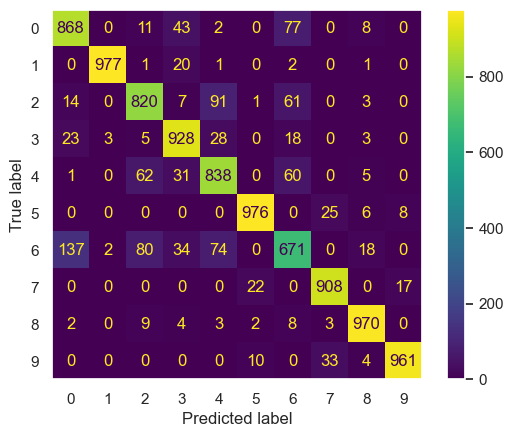

In [63]:
show_confusion_matrix(y_val,y_val_pred_svc)

**Observations**: From the training and validation metrics, the model seems to be neither overfitting nor underfitting, since there is less difference between training and validation scores for all metrics, with validation scores being lower as expected. The time required for execution is also not too much i.e. around 4 minutes. This is a good sign! Now, let us see if we can improve the performance of the model using some modifications. 

In [64]:
with open('svc.pkl', 'wb') as f:
    pickle.dump(svc, f)

# SVM with PCA (n_components = 200)

In the previous plain SVM, I applied PCA on the training data, but I did not mention number of components in the 'n_components' hyperparameter of PCA. Hence, X_train_transformed did not go through Dimensionality Reduction and all features were used.

Let us now introduce PCA by mentioning n_components. But how to decide this number?

Using Explained Variances!

PCA allows us to understand how much variance in the data is retained as you increase the number of components. This can be visualized from the plot of cumulative explained variance vs number of components. 

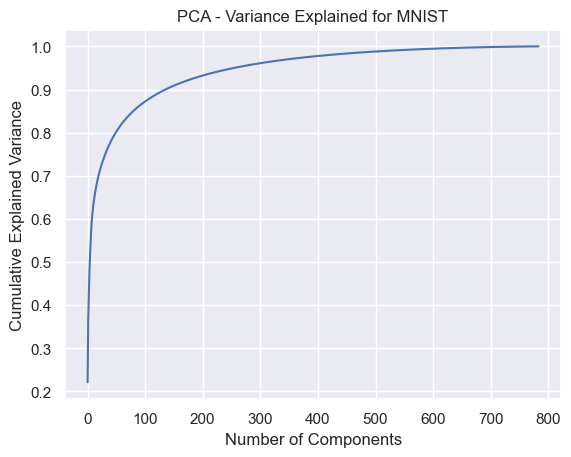

In [47]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Variance Explained for MNIST')
plt.show()

Suppose we want to take top-100 components i.e. features. From the plot, top-100 components will retain between 85% to 90% of the total variance of the original data.

A general approach is to retain 95% to 98% of the total variance, which accounts to approximately top-300 to 400 components for this example. For this project, I have considered **n_components = 200**.

In [49]:
ss = StandardScaler()
pca200 = PCA(n_components=200)
X_train_transformed_pca200 = fit_transform(X_train,ss,pca200)
X_val_transformed_pca200 = transform(X_val,ss,pca200)
X_test_transformed_pca200 = transform(X_test,ss,pca200)

In [54]:
%%time
svc_pca200 = SVC(random_state=42)
svc_pca200.fit(X_train_transformed_pca200,y_train)

CPU times: total: 1min 21s
Wall time: 1min 23s


SVC(random_state=42)

In [55]:
y_train_pred_svc_pca200 = svc_pca200.predict(X_train_transformed_pca200)
y_val_pred_svc_pca200 = svc_pca200.predict(X_val_transformed_pca200)

In [56]:
show_val_scores(y_train_pred_svc_pca200,y_val_pred_svc_pca200)

{'Training Accuracy': 0.913,
 'Validation Accuracy': 0.89,
 'Training Precision': 0.913,
 'Validation Precision': 0.89,
 'Training Recall': 0.913,
 'Validation Recall': 0.891,
 'Training F1 Score': 0.913,
 'Validation F1 Score': 0.89}

In [69]:
print(classification_report(y_val,y_val_pred_svc_pca200,digits=3))

              precision    recall  f1-score   support

           0      0.835     0.867     0.851      1009
           1      0.994     0.973     0.983      1002
           2      0.831     0.823     0.827       997
           3      0.871     0.914     0.892      1008
           4      0.800     0.827     0.814       997
           5      0.964     0.956     0.960      1015
           6      0.745     0.669     0.705      1016
           7      0.933     0.957     0.945       947
           8      0.955     0.970     0.962      1001
           9      0.971     0.951     0.961      1008

    accuracy                          0.890     10000
   macro avg      0.890     0.891     0.890     10000
weighted avg      0.890     0.890     0.890     10000



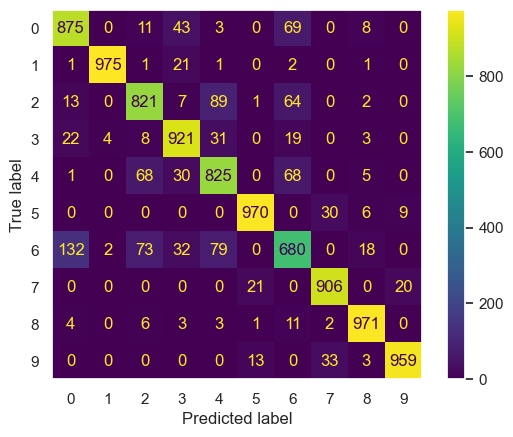

In [57]:
show_confusion_matrix(y_val,y_val_pred_svc_pca200)

**Observations**:
1. Although PCA improved fitting time from 4 minutes to 1 minute, there was no significant change in any of the metrics, for both training and validation data.
2. The model seems to predict the item **Trouser (1)** most correctly, followed by the items **Bag (8), Sandal (5), Ankle boot (9), Sneaker (7), Dress (3), T-shirt/top (0), Coat (4), Pullover (2)** and finally, the item **Shirt (6)** shows very poor classification with correctly predicting only 680 out of 1016 (66.9%) total true **6** labels.
3. For top-5 items i.e. **Trouser, Bag, Sandal, Ankle boot and Sneaker**, these items have very peculiar shape in their respective images and hence occupy a very specific sets of areas in the images, which are not too overlapping. Thus, the model is able to learn these patterns in their images, leading to better performance.
4. For **Shirt**, we can see that it has often been misclassified as **T-shirt/top, Pullover, Dress, Coat or Bag**. This can mean that the model is able to learn the similarities in these items as upper body wearables; since in their images, these items seem to occupy approximately same areas. Similarly, **Pullover** is often misclassified as a **Coat** or a **Shirt**.

Let us perform a Grid Search to obtain optimal hyperparameters for SVC. Here we will only focus on C and gamma.

In [59]:
with open('svc_pca200.pkl', 'wb') as f:
    pickle.dump(svc_pca200, f)

# SVM with PCA (n_components = 200) and GridSearchCV

**C**: Represents the regularization parameter or cost of misclassification. The strength of the regularization is inversely proportional to C.
**gamma**: Kernel coefficient for 'rbf' kernel. It controls the influence of a single training sample in rbf. A higher gamma results in each point having more localized influence, creating a complex decision boundary. A lower gamma spreads the influence, leading to a smoother boundary.

In [74]:
param_grid = {
    'C' : [5,10],
    'gamma' : np.logspace(-9,3,3)
}

In [75]:
svc_cv = SVC(random_state=42)

In [76]:
svc_gs = GridSearchCV(svc_cv,
                      param_grid,
                      scoring='accuracy',
                      cv=5,
                      verbose=1,
                      return_train_score=True)

In [ ]:
%%time
svc_gs.fit(X_train_transformed_pca200,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


As I am typing this, the GridSearhCV is still going on for about 7 hours now. I realised the hard way, that the GridSearchCV for SVC (and in general as well) is, computationally very expensive! Hence, it is absolutely essential to understand what the model hyperparameters mean, to assign them values which can speed up the fitting, to avoid situations like these! :')

In [ ]:
cv_results = pd.DataFrame(svc_gs.cv_results_)
cv_results

In [ ]:
y_train_pred_svc_gs = svc_gs.best_estimator_.predict(X_train_transformed_pca200)
y_val_pred_svc_gs = svc_gs.best_estimator_.predict(X_val_transformed_pca200)

In [ ]:
show_val_scores(y_train_pred_svc_gs,y_val_pred_svc_gs)

In [ ]:
print(classification_report(y_val,y_val_pred_svc_gs,digits=3))

In [ ]:
show_confusion_matrix(y_val,y_val_pred_svc_gs)

In [ ]:
with open('svc_gscv.pkl', 'wb') as f:
    pickle.dump(svc_gs.best_estimator_, f)